In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
!pip install scipy
#!pip install polars
!pip install openpyxl

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import json
from scipy.stats import bootstrap
import scipy.stats as stats
import polars as pl
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.7f}'.format
np.random.seed(42)

In [3]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1)
    fig, ax = plt.subplots()
    ax.hist(res.bootstrap_distribution, bins=25)
    ax.set_title('Bootstrap Distribution')
    ax.set_xlabel(stat_label)
    ax.set_ylabel('frequency')
    plt.show()
    return res

def histo(df):
    df.hist()
    plt.tight_layout()
    plt.show()

In [4]:
features = ['products','helpful','funny', 'hours', 'recommended']

In [5]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [6]:
dfreco = pd.read_parquet("recommendations.parquet").set_index('review_id')
#dfgame = pd.read_csv("games.csv")
#dfuser = pd.read_csv("users.csv")
#dfmeta = pd.read_json('games_metadata.json', lines=False)

In [7]:
df = dfreco.groupby('user_id').agg({'helpful':'sum', 'funny':'sum', 'app_id': 'nunique', 'is_recommended':'sum', 'hours':'sum'}).rename(columns={'app_id': 'products', 'is_recommended':'recommended'})
X = df[features].values

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]
df['single_pca_sort'] = df.single_pca.abs()


In [9]:
std = df[features].std()
inverse_std = 1 / std
total_inverse_std = inverse_std.sum()
weights = inverse_std / total_inverse_std
print(weights)

products      0.4059023
helpful       0.0260522
funny         0.0564568
hours         0.0063831
recommended   0.5052056
dtype: float64


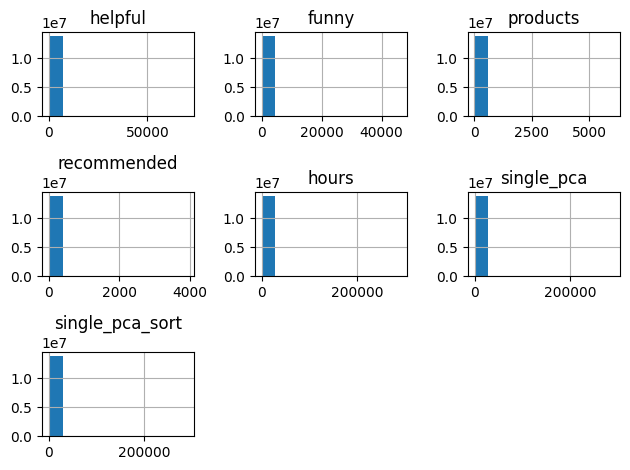

In [10]:
histo(df)
df = df[(df.helpful > 0)&(df.funny > 0)&(df.recommended > 0)&(df.recommended < df.products)&(df.products>10)]

df['weighted_avg'] = df.products*0.4059023 + df.helpful*0.0260522 + df.funny*0.0564568 + df.hours*0.0063831 + df.recommended*0.5052056

df['helpful_rat'] = df.helpful / df.products
df['funny_rat'] = df.funny / df.products
df['recommended_rat'] = df.recommended / df.products
df['hours_rat'] = df.hours / df.products

df = df[df['single_pca_sort'] >= np.percentile(df['single_pca_sort'].values, 95)]

In [11]:
df.describe()

,helpful,funny,products,recommended,hours,single_pca,single_pca_sort,weighted_avg,helpful_rat,funny_rat,recommended_rat,hours_rat
count,"14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000"
mean,707.1836097,177.4699188,86.6708070,67.1070710,"6,395.7401429","6,125.5095432","6,125.5095432",138.3504694,8.3493809,2.7435868,0.7928162,133.2984406
std,"2,161.2706254",783.8762934,141.4088702,100.0309764,"4,663.2676846","4,675.7074552","4,675.7074552",169.8247840,20.5062783,13.7949816,0.1643463,95.4595787
min,2.0000000,2.0000000,11.0000000,1.0000000,"3,412.9000000","4,049.0756801","4,049.0756801",35.7227245,0.0093458,0.0031847,0.0183486,2.0241329
25%,66.0000000,10.0000000,32.0000000,25.0000000,"4,769.9500000","4,485.6246254","4,485.6246254",68.2366809,1.3654119,0.2051282,0.7142857,64.3399855
50%,187.0000000,33.0000000,54.0000000,42.0000000,"5,436.0000000","5,152.5534937","5,152.5534937",94.7714436,3.2207792,0.5681818,0.8356164,108.5302326
75%,539.0000000,118.0000000,93.0000000,75.0000000,"6,686.3500000","6,419.3982770","6,419.3982770",146.6930152,8.1550481,1.7300823,0.9166667,176.9868802
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","290,694.2000000","290,676.3714859","290,676.3714859","5,031.1218076",798.2000000,876.7142857,0.9988675,889.8714286


In [12]:
X = df[features].values
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X)
scores = iso.decision_function(X)

df["iso"] = outliers
df["iso_score"]  = scores
df['type'] = df['iso'].apply(lambda x: "Outlier" if x == -1 else "Inlier")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14411 entries, 814 to 14305966
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   helpful          14411 non-null  int64  
 1   funny            14411 non-null  int64  
 2   products         14411 non-null  int64  
 3   recommended      14411 non-null  int64  
 4   hours            14411 non-null  float64
 5   single_pca       14411 non-null  float64
 6   single_pca_sort  14411 non-null  float64
 7   weighted_avg     14411 non-null  float64
 8   helpful_rat      14411 non-null  float64
 9   funny_rat        14411 non-null  float64
 10  recommended_rat  14411 non-null  float64
 11  hours_rat        14411 non-null  float64
 12  iso              14411 non-null  int64  
 13  iso_score        14411 non-null  float64
 14  type             14411 non-null  object 
dtypes: float64(9), int64(5), object(1)
memory usage: 1.8+ MB


In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
sns_order = ['Outlier', 'Inlier']

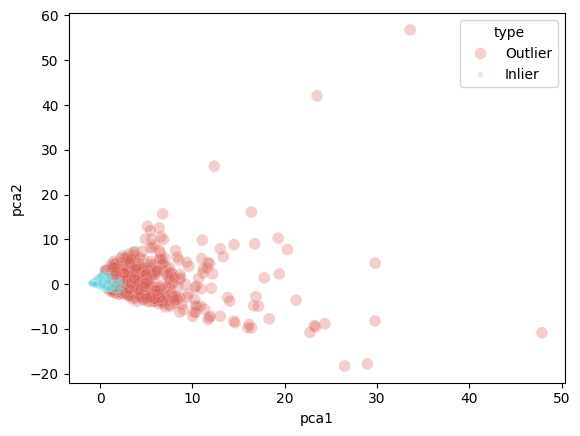

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="pca1", 
    y="pca2", 
    hue="type",
    hue_order = sns_order,
    legend=True,
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

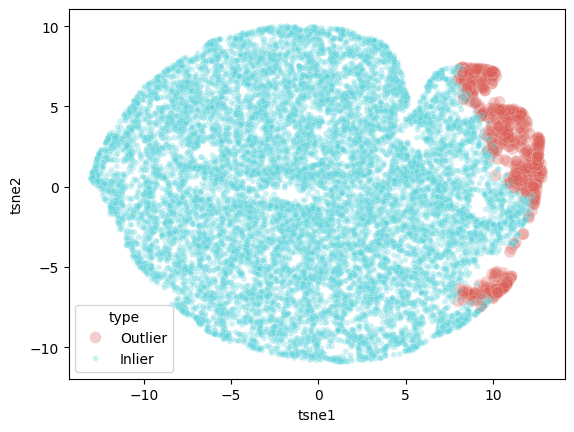

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X)

df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="tsne1", 
    y="tsne2", 
    hue="type",
    hue_order = sns_order,
    legend="full",
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

In [16]:
df_outliers = df[df["iso"] == -1]
df_outliers = df_outliers.sort_values(by='weighted_avg', ascending=False)#['products','helpful','funny', 'hours', 'recommended'], ascending=False)
df_outliers.reset_index(inplace=True)
df_outliers.index = np.arange(1, len(df_outliers)+1)
df_outliers.head()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_outliers.style.format(thousands=',', precision=2))

,user_id,helpful,funny,products,recommended,hours,single_pca,single_pca_sort,weighted_avg,helpful_rat,funny_rat,recommended_rat,hours_rat,iso,iso_score,type,pca1,pca2,tsne1,tsne2
1,"5,112,758","42,745","3,510","4,152","3,920","8,404.20","10,372.77","10,372.77","5,031.12",10.30,0.85,0.94,2.02,-1,-0.27,Outlier,47.85,-10.89,12.60,3.09
2,"5,860,500","70,096","46,186",129,107,"3,922.60","7,833.68","7,833.68","4,565.13",543.38,358.03,0.83,30.41,-1,-0.19,Outlier,33.58,56.77,10.14,7.08
3,"11,764,552","14,962","4,906","6,045",191,"24,249.10","24,792.87","24,792.87","3,371.73",2.48,0.81,0.03,4.01,-1,-0.24,Outlier,29.77,-8.25,12.61,2.85
4,"8,040,965","65,990","1,132","1,673","1,633","7,642.10","10,725.20","10,725.20","3,335.95",39.44,0.68,0.98,4.57,-1,-0.25,Outlier,29.79,4.69,11.77,4.43
5,"11,934,022","16,771","43,867",237,209,"34,287.90","35,412.98","35,412.98","3,334.16",70.76,185.09,0.88,144.67,-1,-0.23,Outlier,23.50,42.05,10.08,7.12
6,"13,933,393","13,273",814,"1,274","1,024","290,694.20","290,676.37","290,676.37","3,281.73",10.42,0.64,0.80,228.17,-1,-0.26,Outlier,28.94,-17.84,10.79,-5.99
7,"12,231,744","4,406","1,251","1,684",889,"264,264.60","263,842.78","263,842.78","3,004.91",2.62,0.74,0.53,156.93,-1,-0.24,Outlier,26.49,-18.29,10.79,-5.99
8,"1,353,327","16,203",683,"2,272","2,262","7,672.20","8,226.78","8,226.78","2,574.64",7.13,0.30,1.00,3.38,-1,-0.24,Outlier,24.34,-8.86,12.63,2.98
9,"1,365,585","10,381","1,301","2,470","2,081","12,640.30","12,900.85","12,900.85","2,478.49",4.20,0.53,0.84,5.12,-1,-0.23,Outlier,23.33,-9.55,12.64,2.96
10,"4,457,971","10,209","1,431","2,720","1,948","6,028.30","6,292.63","6,292.63","2,473.43",3.75,0.53,0.72,2.22,-1,-0.22,Outlier,23.20,-9.28,12.64,2.95


In [17]:
print(f'Original user count: {dfreco.user_id.nunique()}')
print(f'User candidate count: {len(df)}')
print(f'Anomaly user count: {len(df_outliers)}')

Original user count: 13781059
User candidate count: 14411
Anomaly user count: 721


In [18]:
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 1 to 721
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          721 non-null    int64  
 1   helpful          721 non-null    int64  
 2   funny            721 non-null    int64  
 3   products         721 non-null    int64  
 4   recommended      721 non-null    int64  
 5   hours            721 non-null    float64
 6   single_pca       721 non-null    float64
 7   single_pca_sort  721 non-null    float64
 8   weighted_avg     721 non-null    float64
 9   helpful_rat      721 non-null    float64
 10  funny_rat        721 non-null    float64
 11  recommended_rat  721 non-null    float64
 12  hours_rat        721 non-null    float64
 13  iso              721 non-null    int64  
 14  iso_score        721 non-null    float64
 15  type             721 non-null    object 
 16  pca1             721 non-null    float64
 17  pca2             721 

In [19]:
df_outliers.describe()

,user_id,helpful,funny,products,recommended,hours,single_pca,single_pca_sort,weighted_avg,helpful_rat,funny_rat,recommended_rat,hours_rat,iso,iso_score,pca1,pca2,tsne1,tsne2
count,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000
mean,"8,134,238.0707351","6,020.0319001","1,525.0568655",411.7808599,307.7919556,"12,844.3109570","12,858.0368529","12,858.0368529",647.5624445,36.0284808,16.5231885,0.8125769,71.6657576,-1.0000000,-0.0874830,4.6615632,0.4145185,10.7955132,1.8504441
std,"3,766,526.5886748","7,346.4300161","3,078.9889463",474.4788038,316.7712038,"17,470.2211892","17,422.2757271","17,422.2757271",476.5738070,68.7110924,55.8326485,0.1727030,96.8668581,0.0000000,0.0650233,4.4024475,4.4501693,1.3200095,4.2728639
min,"1,239.0000000",7.0000000,2.0000000,14.0000000,4.0000000,"3,412.9000000","4,052.2459030","4,052.2459030",231.7789338,0.0358515,0.0031847,0.0183486,2.0241329,-1.0000000,-0.2728651,0.5712721,-18.2893479,7.9676332,-7.4398441
25%,"5,257,358.0000000","1,475.0000000",177.0000000,140.0000000,112.0000000,"5,569.1000000","5,656.3126341","5,656.3126341",402.7320979,3.7674419,0.4451295,0.7451923,14.7663366,-1.0000000,-0.1362497,2.3443705,-1.7810079,9.8249340,0.3358916
50%,"8,604,997.0000000","4,063.0000000",690.0000000,322.0000000,248.0000000,"8,119.7000000","8,226.7815818","8,226.7815818",506.1738839,15.2606061,1.9512821,0.8584337,31.6645429,-1.0000000,-0.0753062,3.4086814,-0.1110157,10.7880516,2.6578681
75%,"11,441,822.0000000","7,830.0000000","1,934.0000000",502.0000000,377.0000000,"14,049.2000000","14,002.5325083","14,002.5325083",714.5425805,41.9843750,11.2058824,0.9333333,81.2185841,-1.0000000,-0.0331089,5.1942819,2.4006621,12.0939693,4.7402773
max,"14,294,119.0000000","70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","290,694.2000000","290,676.3714859","290,676.3714859","5,031.1218076",798.2000000,876.7142857,0.9988675,534.6913978,-1.0000000,-0.0000662,47.8526521,56.7749244,12.8059006,7.4465494


In [22]:
df_outliers.to_excel('outlier_users.xlsx')